Using device: cuda

===== Training MNIST with Learning Rate: 0.0001, Epochs: 5 =====
Top 5 Hessian Eigenvalues for MNIST: [19.81748  21.776443 24.7765   27.5814   27.930523]
MNIST Model - Final Training Loss: 1.5627, Test Loss: 1.5409, Loss Difference: 0.0079

===== Training FashionMNIST with Learning Rate: 0.0001, Epochs: 5 =====
Top 5 Hessian Eigenvalues for FashionMNIST: [12.62114  13.406024 15.366277 17.852777 18.427788]
FashionMNIST Model - Final Training Loss: 1.2245, Test Loss: 1.2037, Loss Difference: 0.0122

===== Training MNIST with Learning Rate: 0.0001, Epochs: 10 =====
Top 5 Hessian Eigenvalues for MNIST: [24.567123 25.298637 27.651337 29.622997 31.698235]
MNIST Model - Final Training Loss: 0.9956, Test Loss: 1.0560, Loss Difference: 0.0179

===== Training FashionMNIST with Learning Rate: 0.0001, Epochs: 10 =====
Top 5 Hessian Eigenvalues for FashionMNIST: [20.456764 23.859964 23.887842 28.652027 28.652039]
FashionMNIST Model - Final Training Loss: 0.8122, Test Loss: 0.872

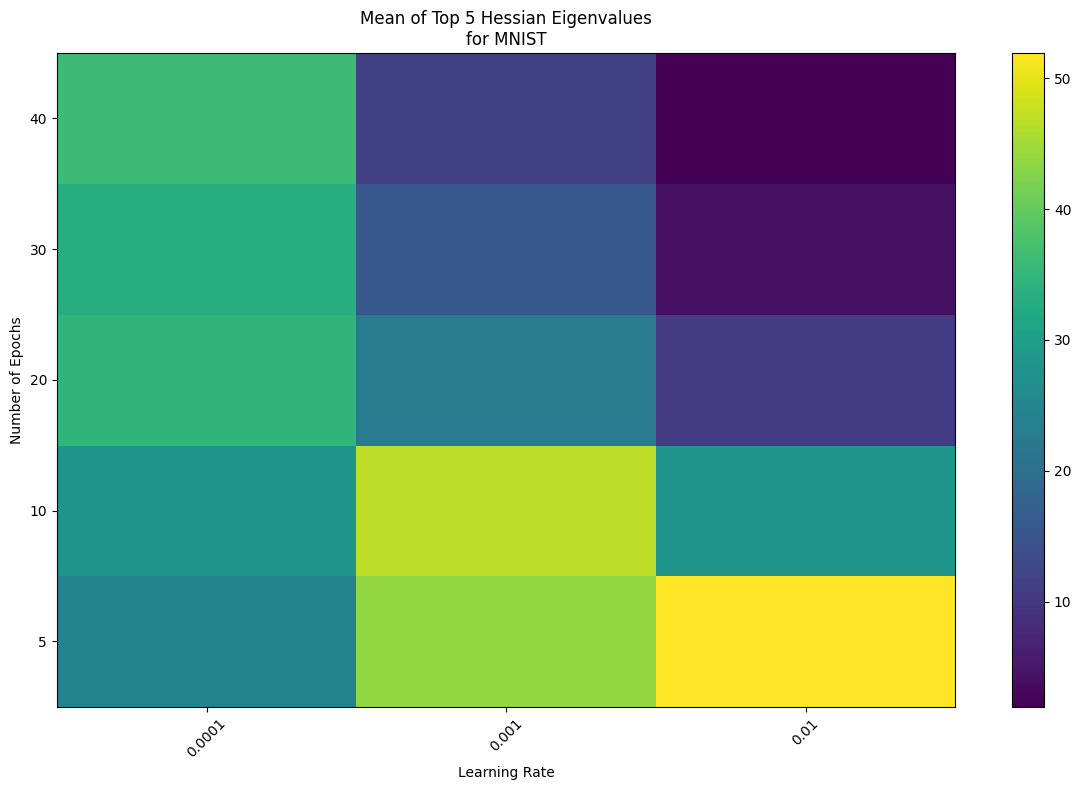

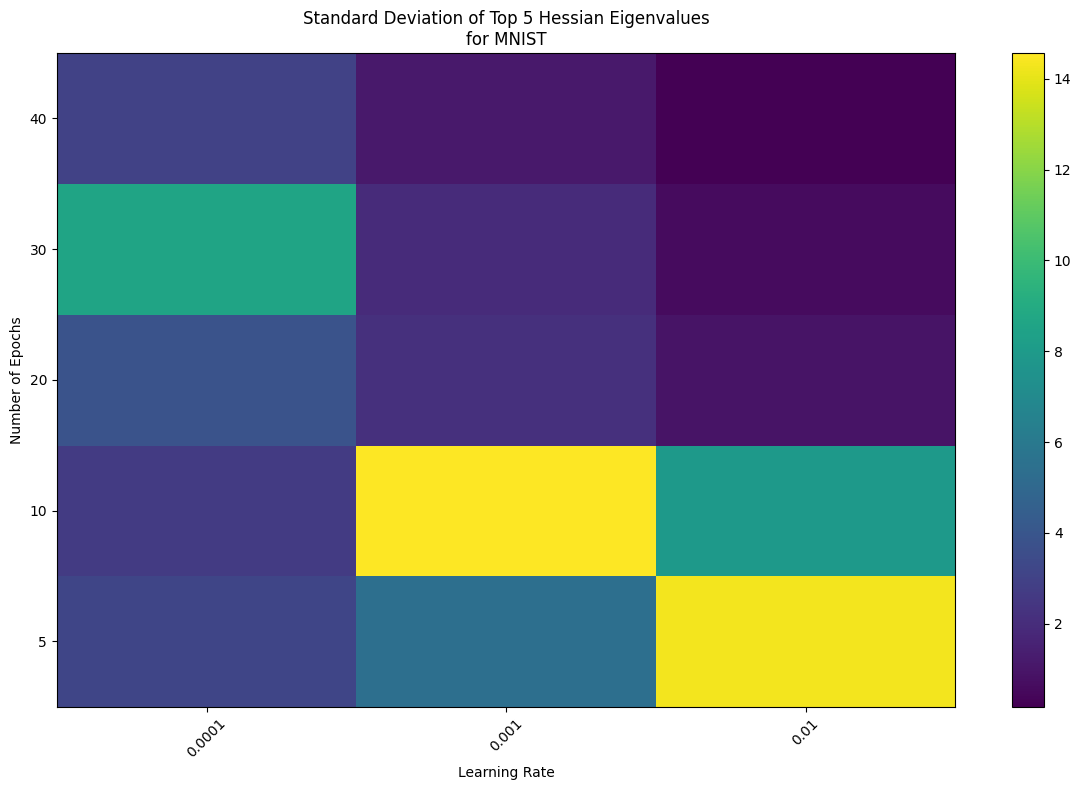

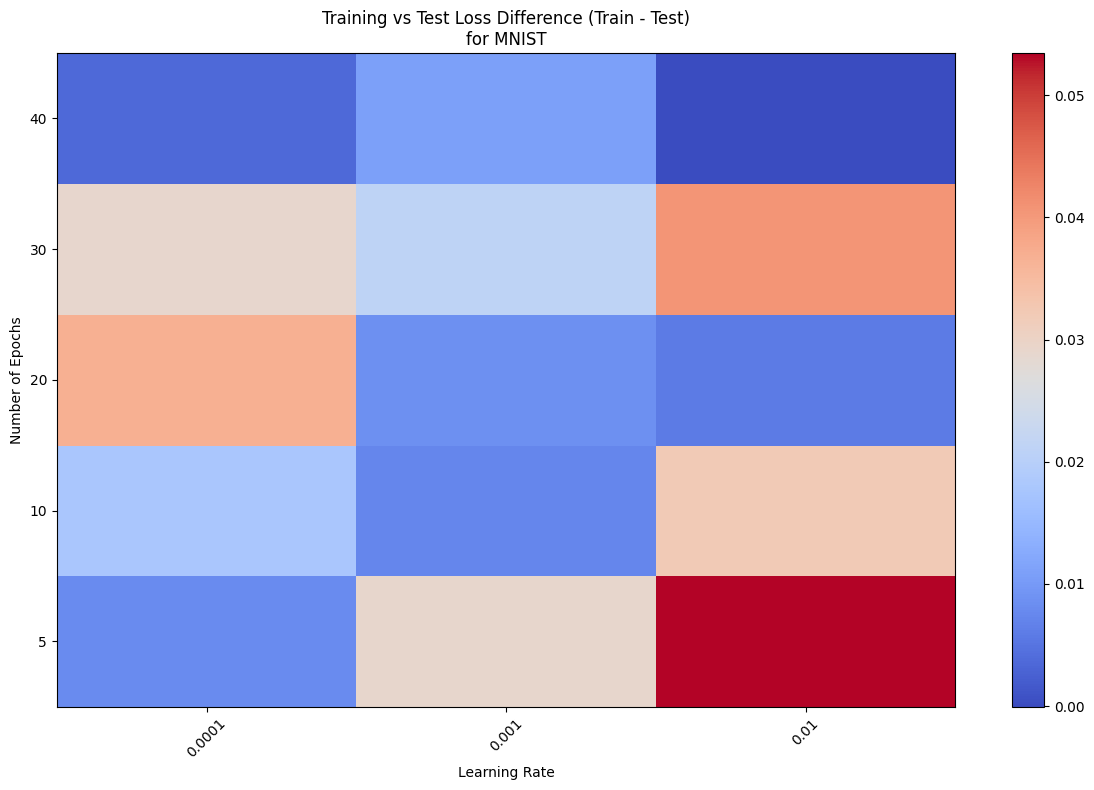

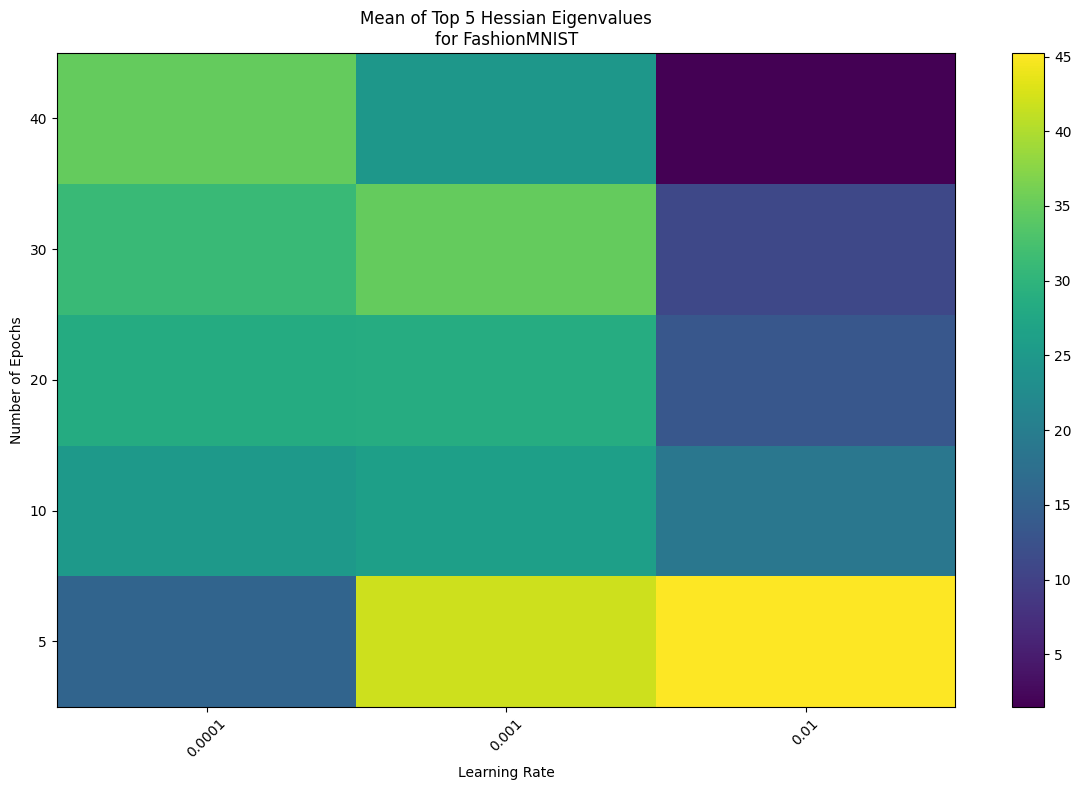

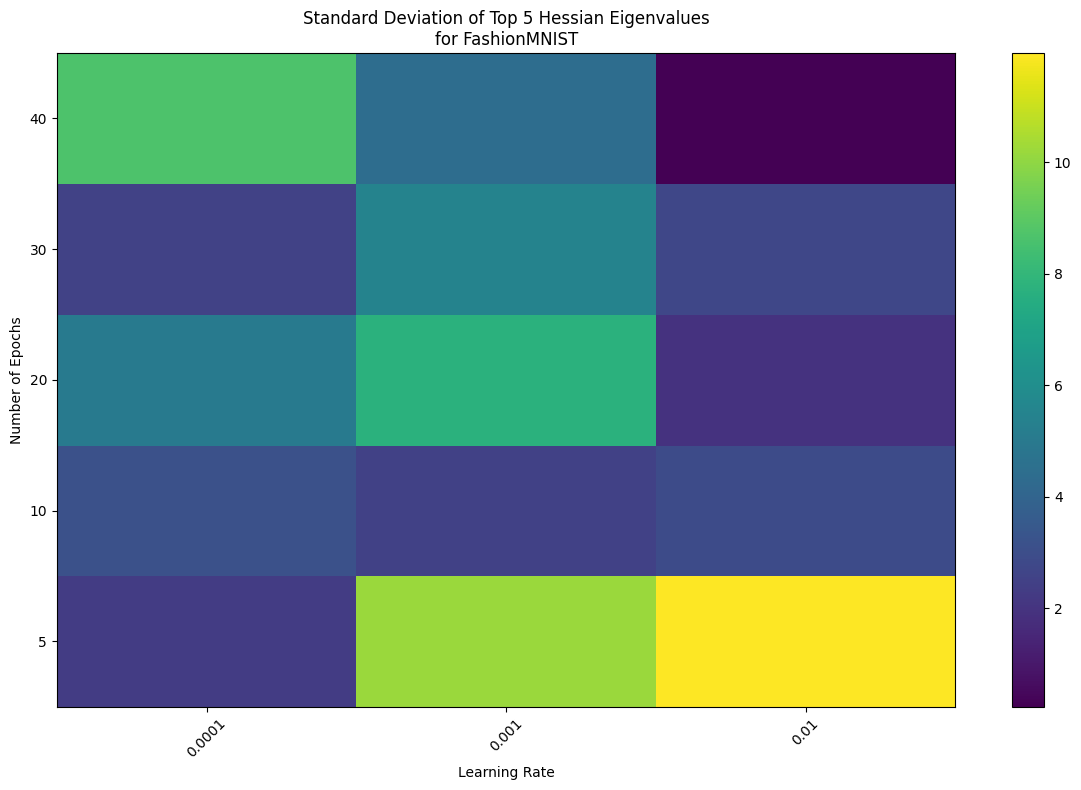

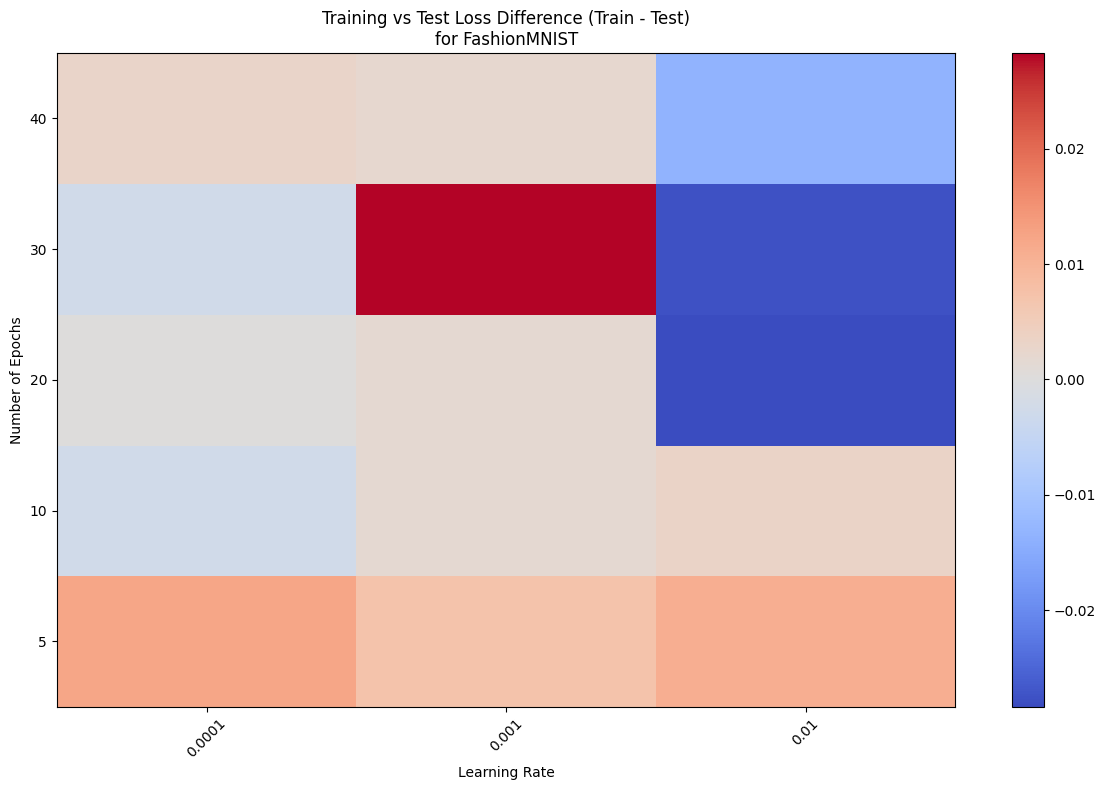


===== Summary of Experiments =====

----- MNIST -----
Learning Rate: 0.0001, Epochs: 5 => Top 5 Hessian Eigenvalues: [19.81748  21.776443 24.7765   27.5814   27.930523], Training Loss: 1.5627, Test Loss: 1.5409, Loss Difference: 0.0079
Learning Rate: 0.0001, Epochs: 10 => Top 5 Hessian Eigenvalues: [24.567123 25.298637 27.651337 29.622997 31.698235], Training Loss: 0.9956, Test Loss: 1.0560, Loss Difference: 0.0179
Learning Rate: 0.0001, Epochs: 20 => Top 5 Hessian Eigenvalues: [28.572071 33.361187 33.423584 38.82096  38.82098 ], Training Loss: 0.5936, Test Loss: 0.6895, Loss Difference: 0.0368
Learning Rate: 0.0001, Epochs: 30 => Top 5 Hessian Eigenvalues: [25.17237  26.17284  27.124191 43.618034 43.618034], Training Loss: 0.4504, Test Loss: 0.5718, Loss Difference: 0.0289
Learning Rate: 0.0001, Epochs: 40 => Top 5 Hessian Eigenvalues: [32.41472  32.65361  37.53656  39.056286 39.070183], Training Loss: 0.3739, Test Loss: 0.4970, Loss Difference: 0.0036
Learning Rate: 0.001, Epochs: 5

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 64
subset_size = 1000  # Number of examples to use from each dataset for faster experiments
save_dir = "./saved_states"  # Directory to save the model and optimizer states
os.makedirs(save_dir, exist_ok=True)

# Hyperparameters for experiments
epochs_list = [5, 10, 20, 30, 40]
learning_rates = [0.0001, 0.001, 0.01]
num_eigenvalues = 5  # Number of top Hessian eigenvalues to compute

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A simple neural network with one hidden layer.
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# 3. Helper Functions
# ===========================

def load_subset_data(transform, dataset, subset_size=1000):
    """
    Loads a subset of the specified dataset.
    """
    if dataset == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    train_subset = torch.utils.data.Subset(train_dataset, np.arange(subset_size))
    test_subset = torch.utils.data.Subset(test_dataset, np.arange(max(100, subset_size // 10)))  # Smaller test set
    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train_model(model, train_loader, optimizer, criterion, num_epochs, device):
    """
    Trains the model and records training loss.
    """
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
    return train_losses

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test set and records test loss and accuracy.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy

def compute_hvp(model, loss, params, v):
    """
    Computes the Hessian-vector product (HVP) for a given vector v.
    
    Args:
        model: The neural network model.
        loss: The loss tensor.
        params: List of model parameters.
        v: Vector to multiply with Hessian.
    
    Returns:
        hvp: Hessian-vector product.
    """
    grads = torch.autograd.grad(loss, params, create_graph=True)
    grad_vector = torch.cat([g.contiguous().view(-1) for g in grads])
    hvp = torch.autograd.grad(grad_vector, params, grad_outputs=v, retain_graph=True)
    hvp_vector = torch.cat([h.contiguous().view(-1) for h in hvp])
    return hvp_vector

def lanczos_algorithm(model, data_loader, criterion, num_iterations=20, num_eigenvalues=5):
    """
    Implements the Lanczos algorithm to approximate the top k eigenvalues of the Hessian.
    
    Args:
        model: The neural network model.
        data_loader: DataLoader for the dataset.
        criterion: Loss function.
        num_iterations: Number of Lanczos iterations.
        num_eigenvalues: Number of top eigenvalues to approximate.
    
    Returns:
        top_eigenvalues: Approximated top k eigenvalues.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Get model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    
    # Initialize Lanczos vectors
    param_num = sum(p.numel() for p in params)
    q = torch.randn(param_num, device=device)
    q = q / q.norm()
    
    alphas = []
    betas = []
    
    q_prev = torch.zeros(param_num, device=device)
    
    for i in range(num_iterations):
        # Compute Hessian-vector product
        hvp = compute_hvp(model, loss, params, q).detach()
        
        if i > 0:
            hvp = hvp - betas[-1] * q_prev
        
        alpha = torch.dot(q, hvp).item()
        alphas.append(alpha)
        
        # Compute the residual
        hvp = hvp - alpha * q
        beta = hvp.norm().item()
        betas.append(beta)
        
        if beta < 1e-6:
            break
        
        # Update vectors
        q_prev = q.clone()
        q = hvp / beta
    
    # Build tridiagonal matrix
    T = torch.diag(torch.tensor(alphas, device=device))
    if len(betas) > 1:
        T += torch.diag(torch.tensor(betas[:-1], device=device), diagonal=1)
        T += torch.diag(torch.tensor(betas[:-1], device=device), diagonal=-1)
    
    # Compute eigenvalues using torch.linalg.eigvals
    with torch.no_grad():
        eigenvalues = torch.linalg.eigvals(T).real.cpu().numpy()
    
    # Get the top k eigenvalues
    top_eigenvalues = np.sort(eigenvalues)[-num_eigenvalues:]
    return top_eigenvalues

def perturb_and_evaluate(model, data_loader, criterion, perturbation_scale=0.01):
    """
    Perturbs the model parameters with random noise and evaluates the loss difference.
    
    Args:
        model: The neural network model.
        data_loader: DataLoader for the dataset.
        criterion: Loss function.
        perturbation_scale: Scale of the perturbation noise.
    
    Returns:
        original_loss: Loss before perturbation.
        perturbed_loss: Loss after perturbation.
        loss_difference: Difference between perturbed and original loss.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Compute original loss
    with torch.no_grad():
        outputs = model(inputs)
        original_loss = criterion(outputs, targets).item()
    
    # Perturb the model parameters
    perturbed_model = SimpleNet().to(device)
    perturbed_model.load_state_dict(model.state_dict())
    
    with torch.no_grad():
        for param in perturbed_model.parameters():
            noise = perturbation_scale * torch.randn_like(param)
            param += noise

    # Compute perturbed loss
    with torch.no_grad():
        outputs_perturbed = perturbed_model(inputs)
        perturbed_loss = criterion(outputs_perturbed, targets).item()
    
    # Loss difference
    loss_difference = perturbed_loss - original_loss
    return original_loss, perturbed_loss, loss_difference

# ===========================
# 4. Visualization Functions
# ===========================

def plot_heatmap(data_matrix, x_labels, y_labels, title, xlabel, ylabel, cmap='viridis'):
    """
    Plots a heatmap for the given data matrix.
    
    Args:
        data_matrix: 2D numpy array.
        x_labels: Labels for the x-axis.
        y_labels: Labels for the y-axis.
        title: Title of the heatmap.
        xlabel: Label for the x-axis.
        ylabel: Label for the y-axis.
        cmap: Color map.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(data_matrix, aspect='auto', cmap=cmap, origin='lower')
    plt.colorbar()
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_eigenvalue_stats(mean_matrix, std_matrix, x_labels, y_labels, dataset_name):
    """
    Plots heatmaps for mean and standard deviation of eigenvalues.
    
    Args:
        mean_matrix: 2D numpy array of mean eigenvalues.
        std_matrix: 2D numpy array of standard deviation of eigenvalues.
        x_labels: Learning rates.
        y_labels: Number of epochs.
        dataset_name: Name of the dataset.
    """
    # Plot Mean Eigenvalues Heatmap
    plot_heatmap(mean_matrix, x_labels, y_labels, 
                title=f'Mean of Top {num_eigenvalues} Hessian Eigenvalues\nfor {dataset_name}',
                xlabel='Learning Rate',
                ylabel='Number of Epochs')
    
    # Plot Std Eigenvalues Heatmap
    plot_heatmap(std_matrix, x_labels, y_labels, 
                title=f'Standard Deviation of Top {num_eigenvalues} Hessian Eigenvalues\nfor {dataset_name}',
                xlabel='Learning Rate',
                ylabel='Number of Epochs')

def plot_loss_difference_heatmap(loss_diff_matrix, x_labels, y_labels, dataset_name):
    """
    Plots a heatmap for loss differences.
    
    Args:
        loss_diff_matrix: 2D numpy array of loss differences.
        x_labels: Learning rates.
        y_labels: Number of epochs.
        dataset_name: Name of the dataset.
    """
    plot_heatmap(loss_diff_matrix, x_labels, y_labels, 
                title=f'Training vs Test Loss Difference (Train - Test)\nfor {dataset_name}',
                xlabel='Learning Rate',
                ylabel='Number of Epochs',
                cmap='coolwarm')

# ===========================
# 5. Main Execution Loop
# ===========================

def main():
    # Define the transforms for the datasets
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Prepare to store results
    # Structure: results[dataset][lr][epochs] = {'eigenvalues': [...], 'train_loss': ..., 'test_loss': ...}
    results = {
        'MNIST': {lr: {} for lr in learning_rates},
        'FashionMNIST': {lr: {} for lr in learning_rates}
    }
    
    # Iterate over hyperparameter combinations
    for lr in learning_rates:
        for epochs in epochs_list:
            for dataset in ['MNIST', 'FashionMNIST']:
                print(f"\n===== Training {dataset} with Learning Rate: {lr}, Epochs: {epochs} =====")
                # Initialize model and optimizer
                model = SimpleNet().to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.CrossEntropyLoss()
                
                # Load data
                train_loader, test_loader = load_subset_data(transform, dataset, subset_size=subset_size)
                
                # Train the model
                train_losses = train_model(model, train_loader, optimizer, criterion, epochs, device)
                
                # Evaluate the model
                test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
                
                # Perform stability analysis (compute top Hessian eigenvalues)
                top_eigenvalues = lanczos_algorithm(model, train_loader, criterion, num_iterations=20, num_eigenvalues=num_eigenvalues)
                print(f"Top {num_eigenvalues} Hessian Eigenvalues for {dataset}: {top_eigenvalues}")
                
                # Perturb and evaluate
                original_loss, perturbed_loss, loss_diff = perturb_and_evaluate(model, test_loader, criterion, perturbation_scale=0.01)
                print(f"{dataset} Model - Final Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_loss:.4f}, Loss Difference: {loss_diff:.4f}")
                
                # Store eigenvalues and loss differences
                results[dataset][lr][epochs] = {
                    'eigenvalues': top_eigenvalues,
                    'train_loss': train_losses[-1],
                    'test_loss': test_loss,
                    'loss_difference': loss_diff
                }
    
    # ===========================
    # 6. Visualization
    # ===========================
    
    for dataset in ['MNIST', 'FashionMNIST']:
        # Prepare matrices for heatmaps
        mean_eigenvalues = np.zeros((len(epochs_list), len(learning_rates)))
        std_eigenvalues = np.zeros((len(epochs_list), len(learning_rates)))
        loss_diff_matrix = np.zeros((len(epochs_list), len(learning_rates)))
        
        for i, epochs in enumerate(epochs_list):
            for j, lr in enumerate(learning_rates):
                eigenvals = results[dataset][lr][epochs]['eigenvalues']
                mean_eigenvalues[i, j] = np.mean(eigenvals)
                std_eigenvalues[i, j] = np.std(eigenvals)
                # Store loss difference (Train Loss - Test Loss)
                loss_diff_matrix[i, j] = results[dataset][lr][epochs]['loss_difference']
        
        # Plot Mean and Std Eigenvalues Heatmaps
        plot_eigenvalue_stats(mean_eigenvalues, std_eigenvalues, learning_rates, epochs_list, dataset)
        
        # Plot Loss Difference Heatmap
        plot_loss_difference_heatmap(loss_diff_matrix, learning_rates, epochs_list, dataset)
    
    # ===========================
    # 7. Summary Printouts
    # ===========================
    
    print("\n===== Summary of Experiments =====\n")
    for dataset in ['MNIST', 'FashionMNIST']:
        print(f"----- {dataset} -----")
        for lr in learning_rates:
            for epochs in epochs_list:
                eigenvals = results[dataset][lr][epochs]['eigenvalues']
                train_loss = results[dataset][lr][epochs]['train_loss']
                test_loss = results[dataset][lr][epochs]['test_loss']
                loss_diff = results[dataset][lr][epochs]['loss_difference']
                print(f"Learning Rate: {lr}, Epochs: {epochs} => Top {num_eigenvalues} Hessian Eigenvalues: {eigenvals}, "
                      f"Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Loss Difference: {loss_diff:.4f}")
        print("\n")

if __name__ == '__main__':
    main()


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import cosine_similarity


# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration Parameters
batch_size = 64
num_epochs = 20
learning_rate = 0.001
subset_size = 10000  # Number of examples to use from each dataset
save_dir = "./saved_states"  # Directory to save the model and optimizer states
model_save_prefix_mnist = os.path.join(save_dir, 'mnist')
model_save_prefix_fashion = os.path.join(save_dir, 'fashion')

# Create directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# ===========================
# 2. Model Definition
# ===========================
class SimpleNet(nn.Module):
    """
    A simple neural network with one hidden layer.
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# ===========================
# 3. Training Function
# ===========================

def train_and_save(model, train_loader, optimizer, criterion, num_epochs, path_prefix, device):
    """
    Train the model and save the model and optimizer state after each epoch.
    """
    model.train()
    loss_list = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            # Move inputs and targets to the same device as the model
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        epoch_loss /= len(train_loader)
        loss_list.append(epoch_loss)
        
        # Save model and optimizer state after each epoch
        save_model_state(model, optimizer, epoch, path_prefix)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")
    
    return loss_list

# ===========================
# 4. Helper Functions
# ===========================

def save_model_state(model, optimizer, epoch, path_prefix):
    torch.save(model.state_dict(), f"{path_prefix}_model_epoch_{epoch}.pth")
    torch.save(optimizer.state_dict(), f"{path_prefix}_optimizer_epoch_{epoch}.pth")

def load_model_state(model, optimizer, epoch, path_prefix):
    model.load_state_dict(torch.load(f"{path_prefix}_model_epoch_{epoch}.pth"))
    optimizer.load_state_dict(torch.load(f"{path_prefix}_optimizer_epoch_{epoch}.pth"))

# ===========================
# 5. Cosine Similarity Functions
# ===========================

def compute_cosine_similarity(state1, state2):
    """
    Computes the cosine similarity between two model parameter states.
    """
    similarities = {}
    for key in state1.keys():
        if key in state2:
            param1 = state1[key].view(-1)
            param2 = state2[key].view(-1)
            sim = cosine_similarity(param1.unsqueeze(0), param2.unsqueeze(0), dim=1)
            similarities[key] = sim.item()
    return similarities

def compute_optimizer_cosine_similarity(opt_state1, opt_state2):
    """
    Computes the cosine similarity between the states of two optimizers.
    Specifically compares the 'exp_avg' and 'exp_avg_sq' tensors in the optimizer state.
    """
    similarities = {}
    for key in opt_state1.keys():
        str_key = str(key)  # Convert integer key to string
        if key in opt_state2:
            # Check if the states contain 'exp_avg' and 'exp_avg_sq'
            if 'exp_avg' in opt_state1[key] and 'exp_avg' in opt_state2[key]:
                param1 = opt_state1[key]['exp_avg'].view(-1)
                param2 = opt_state2[key]['exp_avg'].view(-1)
                sim = cosine_similarity(param1.unsqueeze(0), param2.unsqueeze(0), dim=1)
                similarities[str_key + '_exp_avg'] = sim.item()
            if 'exp_avg_sq' in opt_state1[key] and 'exp_avg_sq' in opt_state2[key]:
                param1 = opt_state1[key]['exp_avg_sq'].view(-1)
                param2 = opt_state2[key]['exp_avg_sq'].view(-1)
                sim = cosine_similarity(param1.unsqueeze(0), param2.unsqueeze(0), dim=1)
                similarities[str_key + '_exp_avg_sq'] = sim.item()
    return similarities

# ===========================
# 6. Plotting Function
# ===========================

def plot_cosine_similarity(similarities, title):
    plt.figure(figsize=(10, 5))
    for key in similarities.keys():
        plt.plot(similarities[key], label=key)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.show()

# ===========================
# 7. Main Function
# ===========================

def main():
    # Define the transforms for the datasets
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Load a subset of MNIST dataset (100 examples)
    print("Loading MNIST dataset...")
    mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_subset = torch.utils.data.Subset(mnist_train_dataset, np.arange(subset_size))
    mnist_train_loader = torch.utils.data.DataLoader(mnist_subset, batch_size=batch_size, shuffle=True)

    # Load a subset of FashionMNIST dataset (100 examples)
    print("Loading FashionMNIST dataset...")
    fashion_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    fashion_subset = torch.utils.data.Subset(fashion_train_dataset, np.arange(subset_size))
    fashion_train_loader = torch.utils.data.DataLoader(fashion_subset, batch_size=batch_size, shuffle=True)

    # Initialize models, optimizers, and loss function
    model_mnist = SimpleNet().to(device)
    model_fashion = SimpleNet().to(device)
    optimizer_mnist = optim.Adam(model_mnist.parameters(), lr=learning_rate)
    optimizer_fashion = optim.Adam(model_fashion.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train on MNIST and save states
    print("Training on MNIST...")
    mnist_loss = train_and_save(model_mnist, mnist_train_loader, optimizer_mnist, criterion, num_epochs, path_prefix=model_save_prefix_mnist, device=device)

    # Train on FashionMNIST and save states
    print("Training on FashionMNIST...")
    fashion_loss = train_and_save(model_fashion, fashion_train_loader, optimizer_fashion, criterion, num_epochs, path_prefix=model_save_prefix_fashion, device=device)

    # Analyze and plot the results
    model_cosine_similarities = []
    optimizer_cosine_similarities = []

    for epoch in range(num_epochs):
        # Load states for both models
        load_model_state(model_mnist, optimizer_mnist, epoch, path_prefix=model_save_prefix_mnist)
        load_model_state(model_fashion, optimizer_fashion, epoch, path_prefix=model_save_prefix_fashion)

        # Get the state dictionaries
        mnist_model_state = model_mnist.state_dict()
        fashion_model_state = model_fashion.state_dict()
        mnist_optimizer_state = optimizer_mnist.state_dict()['state']
        fashion_optimizer_state = optimizer_fashion.state_dict()['state']

        # Compute cosine similarities for models
        model_similarity = compute_cosine_similarity(mnist_model_state, fashion_model_state)
        model_cosine_similarities.append(model_similarity)

        # Compute cosine similarities for optimizers
        optimizer_similarity = compute_optimizer_cosine_similarity(mnist_optimizer_state, fashion_optimizer_state)
        optimizer_cosine_similarities.append(optimizer_similarity)

    # Plot the losses
    plt.figure(figsize=(10, 5))
    plt.plot(mnist_loss, label='MNIST Loss')
    plt.plot(fashion_loss, label='FashionMNIST Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Prepare data for cosine similarity plots
    model_cosine_values = {key: [] for key in model_cosine_similarities[0].keys()}
    optimizer_cosine_values = {key: [] for key in optimizer_cosine_similarities[0].keys()}

    for model_sim in model_cosine_similarities:
        for key in model_sim.keys():
            model_cosine_values[key].append(model_sim[key])

    for optimizer_sim in optimizer_cosine_similarities:
        for key in optimizer_sim.keys():
            optimizer_cosine_values[key].append(optimizer_sim[key])

    # Plot cosine similarities for models
    plot_cosine_similarity(model_cosine_values, 'Cosine Similarity of Model Parameters Over Epochs')

    # Plot cosine similarities for optimizers
    plot_cosine_similarity(optimizer_cosine_values, 'Cosine Similarity of Optimizer States Over Epochs')

# ===========================
# 8. Execution
# ===========================

if __name__ == '__main__':
    main()


Loading MNIST model...


FileNotFoundError: Model file ./saved_states/mnist_model_epoch_9.pth not found. Ensure the model is saved in the specified path.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ===========================
# 1. Setup and Configuration
# ===========================

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_dir = "./saved_states"  # Directory to load the model states

# Check if the directory exists
if not os.path.exists(save_dir):
    raise FileNotFoundError(f"Directory {save_dir} does not exist. Make sure to run the training script first.")

# Configuration Parameters
batch_size = 64
num_epochs = 20
learning_rate = 0.001
subset_size = 10000  # Number of examples to use from each dataset

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A simple neural network with one hidden layer.
    """
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ===========================
# 3. Helper Functions
# ===========================

def load_subset_data(transform, dataset, subset_size=100):
    """
    Loads a subset of the specified dataset.
    """
    if dataset == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    elif dataset == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    subset = torch.utils.data.Subset(train_dataset, np.arange(subset_size))
    train_loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=True)
    return train_loader

def load_model(model_path):
    """
    Loads the model state from the specified path.
    """
    model = SimpleNet().to(device)
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found. Ensure the model is saved in the specified path.")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def compute_hvp(model, loss, params, v):
    """
    Computes the Hessian-vector product (HVP) for a given vector v.
    """
    grads = torch.autograd.grad(loss, params, create_graph=True, retain_graph=True)
    grad_vector = torch.cat([g.contiguous().view(-1) for g in grads])
    hvp = torch.autograd.grad(grad_vector, params, grad_outputs=v, retain_graph=True)
    hvp_vector = torch.cat([h.contiguous().view(-1) for h in hvp])
    return hvp_vector

def lanczos_algorithm(model, data_loader, criterion, num_iterations=20, num_eigenvalues=5):
    """
    Implements the Lanczos algorithm to approximate the top k eigenvalues of the Hessian.
    
    Args:
        model: The neural network model.
        data_loader: DataLoader for the dataset.
        criterion: Loss function.
        num_iterations: Number of Lanczos iterations.
        num_eigenvalues: Number of top eigenvalues to approximate.
    
    Returns:
        eigenvalues: Approximated top k eigenvalues.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Get model parameters
    params = [p for p in model.parameters() if p.requires_grad]
    
    # Initialize Lanczos vectors
    q = torch.randn(sum(p.numel() for p in params)).to(device)
    q /= torch.norm(q)
    
    alphas = []
    betas = []
    
    q_prev = torch.zeros_like(q).to(device)
    
    for i in range(num_iterations):
        # Compute H * q
        hvp = compute_hvp(model, loss, params, q).detach()
        
        # Orthogonalize against q_prev
        hvp = hvp - betas[-1] * q_prev if i > 0 else hvp
        
        alpha = torch.dot(q, hvp).item()
        alphas.append(alpha)
        
        # Compute the residual
        hvp = hvp - alpha * q
        beta = torch.norm(hvp).item()
        betas.append(beta)
        
        if beta < 1e-6:
            print(f"Early stopping at iteration {i+1} due to small beta: {beta}")
            break
        
        # Update vectors
        q_prev = q.clone()
        q = hvp / beta
        
    # Build tridiagonal matrix
    T = torch.diag(torch.tensor(alphas)) + torch.diag(torch.tensor(betas[:-1]), diagonal=1) + torch.diag(torch.tensor(betas[:-1]), diagonal=-1)
    
    # Compute eigenvalues using torch.linalg.eig
    L_complex = torch.linalg.eigvals(T)
    
    # Extract real parts of eigenvalues
    eigenvalues_real = L_complex.real.cpu().numpy()
    
    # Get the top k eigenvalues
    top_eigenvalues = np.sort(eigenvalues_real)[-num_eigenvalues:]
    return top_eigenvalues

def perturb_and_evaluate(model, data_loader, criterion, perturbation_scale=0.01):
    """
    Perturbs the model parameters with random noise and evaluates the loss difference.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Compute original loss
    with torch.no_grad():
        outputs = model(inputs)
        original_loss = criterion(outputs, targets).item()
    
    # Perturb the model parameters
    perturbed_model = SimpleNet().to(device)
    perturbed_model.load_state_dict(model.state_dict())
    
    with torch.no_grad():
        for param in perturbed_model.parameters():
            noise = perturbation_scale * torch.randn_like(param)
            param += noise

    # Compute perturbed loss
    with torch.no_grad():
        outputs_perturbed = perturbed_model(inputs)
        perturbed_loss = criterion(outputs_perturbed, targets).item()
    
    # Loss difference
    loss_difference = perturbed_loss - original_loss
    return original_loss, perturbed_loss, loss_difference

def visualize_loss_surface(model, data_loader, criterion, scale=0.1, steps=50):
    """
    Visualizes the loss surface around the minima by perturbing model parameters in two random directions.
    """
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Compute original loss
    with torch.no_grad():
        outputs = model(inputs)
        original_loss = criterion(outputs, targets).item()
    
    # Get model parameters as a single vector
    params = torch.cat([p.view(-1) for p in model.parameters()]).to(device)
    param_length = params.shape[0]
    
    # Generate two random orthogonal directions
    direction1 = torch.randn(param_length).to(device)
    direction1 /= torch.norm(direction1)
    direction2 = torch.randn(param_length).to(device)
    direction2 -= torch.dot(direction2, direction1) * direction1  # Make orthogonal to direction1
    direction2 /= torch.norm(direction2)
    
    # Create grid of perturbations
    alphas = torch.linspace(-scale, scale, steps).to(device)
    betas = torch.linspace(-scale, scale, steps).to(device)
    loss_surface = torch.zeros((steps, steps)).to(device)
    
    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            for j, beta in enumerate(betas):
                perturbed_params = params + alpha * direction1 + beta * direction2
                perturbed_model = SimpleNet().to(device)
                # Assign perturbed parameters
                offset = 0
                for param in perturbed_model.parameters():
                    param_length = param.numel()
                    param.copy_(perturbed_params[offset:offset + param_length].view(param.size()))
                    offset += param_length
                # Compute loss
                outputs_perturbed = perturbed_model(inputs)
                loss_surface[i, j] = criterion(outputs_perturbed, targets).item()
    
    # Convert to CPU for plotting
    loss_surface = loss_surface.cpu().numpy()
    
    # Plot the loss surface
    plt.figure(figsize=(8, 6))
    plt.contourf(alphas.cpu().numpy(), betas.cpu().numpy(), loss_surface, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title('Loss Surface Visualization')
    plt.xlabel('Alpha (Direction 1)')
    plt.ylabel('Beta (Direction 2)')
    plt.show()

def plot_eigenvalues(eigenvalues, title='Hessian Eigenvalues'):
    """
    Plots the distribution of Hessian eigenvalues.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(eigenvalues, bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.show()

# ===========================
# 4. Stability Analysis Functions
# ===========================

def stability_analysis(model, data_loader, criterion):
    """
    Performs stability analysis on the given model.
    """
    print("Starting stability analysis...")
    
    # Step 1: Compute top eigenvalues using Lanczos algorithm
    print("Computing top Hessian eigenvalues using Lanczos algorithm...")
    top_eigenvalues = lanczos_algorithm(model, data_loader, criterion, num_iterations=20, num_eigenvalues=5)
    print(f"Top Hessian Eigenvalues: {top_eigenvalues}")
    plot_eigenvalues(top_eigenvalues, title='Top Hessian Eigenvalues')
    
    # Step 2: Perturb model parameters and evaluate loss difference
    print("Perturbing model parameters and evaluating loss difference...")
    original_loss, perturbed_loss, loss_diff = perturb_and_evaluate(model, data_loader, criterion, perturbation_scale=0.01)
    print(f"Original Loss: {original_loss:.4f}, Perturbed Loss: {perturbed_loss:.4f}, Loss Difference: {loss_diff:.4f}")
    
    # Step 3: Visualize loss surface
    print("Visualizing loss surface around minima...")
    visualize_loss_surface(model, data_loader, criterion, scale=0.1, steps=50)
    
    print("Stability analysis completed.")

# ===========================
# 5. Main Execution
# ===========================

if __name__ == '__main__':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    criterion = nn.CrossEntropyLoss()

    # Load MNIST model and data
    mnist_model_path = os.path.join(save_dir, 'mnist_model_epoch_9.pth')
    print("Loading MNIST model...")
    mnist_model = load_model(mnist_model_path)
    mnist_loader = load_subset_data(transform, 'MNIST', subset_size=subset_size)
    
    # Stability analysis for MNIST model
    print("\nStability Analysis for MNIST Model:")
    stability_analysis(mnist_model, mnist_loader, criterion)
    
    # Load FashionMNIST model and data
    fashion_model_path = os.path.join(save_dir, 'fashion_model_epoch_9.pth')
    print("\nLoading FashionMNIST model...")
    fashion_model = load_model(fashion_model_path)
    fashion_loader = load_subset_data(transform, 'FashionMNIST', subset_size=subset_size)
    
    # Stability analysis for FashionMNIST model
    print("\nStability Analysis for FashionMNIST Model:")
    stability_analysis(fashion_model, fashion_loader, criterion)


